# Task 4: Hyperparameter Optimization

**Goal:** Optimize Random Forest classifier using Bayesian Optimization with Gaussian Process

**Approach:**
1. Load sensor data from pickle file (196 datasets)
2. Extract features dynamically from available sensors
3. Use 10-Fold Stratified Cross-Validation (LOSO not feasible)
4. Optimize hyperparameters using Gaussian Process + Expected Improvement

**Baseline:** Random Forest from Task 3 (F1=0.518)

## Step 1: Load Data and Extract Labels

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.metrics import f1_score, accuracy_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the pkl file from Task 3
pkl_path = '../task3/project_css25.pkl'

with open(pkl_path, 'rb') as f:
    dataset_receiver = pickle.load(f)

print(f"Loaded DatasetReceiver with {len(dataset_receiver.datasets)} datasets")

Loaded DatasetReceiver with 196 datasets


In [3]:
# Extract labeled data - FIXED: Use dataset.name as user_id
labeled_data = []

for dataset in dataset_receiver.datasets:
    if hasattr(dataset, 'labelings') and dataset.labelings:
        labeling = dataset.labelings[0]
        
        for label_data in labeling.labels:
            # Access Label object attributes (not dictionary keys)
            start_time = label_data.start
            end_time = label_data.end
            label_name = label_data.name
            
            # Get time series data
            if hasattr(dataset, 'timeSeries') and dataset.timeSeries:
                ts = dataset.timeSeries[0]
                df = pd.DataFrame(ts.data)
                
                # Convert time column to datetime if it's not already
                if 'time' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['time']):
                    df['time'] = pd.to_datetime(df['time'], unit='ms')
                
                # Convert start_time and end_time to datetime (they are in milliseconds)
                start_dt = pd.to_datetime(start_time, unit='ms')
                end_dt = pd.to_datetime(end_time, unit='ms')
                
                # Filter by time range
                mask = (df['time'] >= start_dt) & (df['time'] <= end_dt)
                segment_df = df[mask].copy()
                
                if len(segment_df) > 0:
                    segment_df['label'] = label_name
                    segment_df['dataset_id'] = dataset._id
                    # FIXED: Use dataset.name as user_id (groups multiple datasets from same user)
                    segment_df['user_id'] = dataset.name if hasattr(dataset, 'name') else dataset._id
                    labeled_data.append(segment_df)

all_labeled_df = pd.concat(labeled_data, ignore_index=True)
print(f"Total labeled data points: {len(all_labeled_df):,}")
print(f"Unique users (by name): {all_labeled_df['user_id'].nunique()}")
print(f"\nLabel distribution:")
print(all_labeled_df['label'].value_counts())

Total labeled data points: 250,752
Unique users (by name): 10

Label distribution:
label
sitting                    104430
walking                     75212
testing                     30498
standing                    21069
jogging                      3844
Walking                      2924
                             2318
running                      1852
Jumping-Jack-Left-Hand       1609
Jumping-Jack-Right-Hand      1409
Running                      1233
Laufen                       1208
Fencing                       768
Scrolling                     708
Gehen                         616
Jogging                       539
Freefall                      438
Testing                        77
Name: count, dtype: int64


In [4]:
# Normalize labels (same as Task 3)
label_mapping = {
    'walking': 'walking',
    'Walking': 'walking',
    'sitting': 'sitting',
    'Sitting': 'sitting',
    'standing': 'standing',
    'Standing': 'standing',
    'running': 'running',
    'Running': 'running'
}

all_labeled_df['label'] = all_labeled_df['label'].map(label_mapping)
all_labeled_df = all_labeled_df.dropna(subset=['label'])

print("Normalized labels:")
print(all_labeled_df['label'].value_counts())

Normalized labels:
label
sitting     104430
walking      78136
standing     21069
running       3085
Name: count, dtype: int64


**Dataset Summary:**
- 196 datasets from 10 users
- 182 datasets with activity labels
- Labels: walking, sitting, standing, running

## Step 2: Dynamic Feature Extraction

**Why Dynamic?**
The pickle file contains datasets with **different sensor types**:
- Some have `accX` (acceleration X-axis)
- Some have `acceleration.x` (device motion)
- Some have `alpha` (orientation angle)
- Some have `orienAlpha` (orientation alpha)

**Solution:** Automatically detect and extract features from whatever sensors are available in each dataset.

**Features per sensor:** mean, std, min, max, median, q25, q75 (7 statistical features)

In [5]:
def extract_features(df):
    """
    Extract statistical features from ALL available numeric sensor columns
    This dynamically adapts to whatever sensors are present in the dataset
    """
    features = {}
    
    # Automatically detect all numeric sensor columns (exclude time and label columns)
    exclude_cols = ['time', 'label', 'dataset_id', 'user_id']
    sensor_cols = [col for col in df.columns 
                   if col not in exclude_cols 
                   and pd.api.types.is_numeric_dtype(df[col])]
    
    # Extract 7 statistical features from each sensor column
    for col in sensor_cols:
        # Only extract features if column has non-null values
        if df[col].notna().sum() > 0:
            features[f'{col}_mean'] = df[col].mean()
            features[f'{col}_std'] = df[col].std()
            features[f'{col}_min'] = df[col].min()
            features[f'{col}_max'] = df[col].max()
            features[f'{col}_median'] = df[col].median()
            features[f'{col}_q25'] = df[col].quantile(0.25)
            features[f'{col}_q75'] = df[col].quantile(0.75)
    
    # Additional derived features if we have 3D acceleration data
    if all(col in df.columns for col in ['accX', 'accY', 'accZ']):
        features['acc_magnitude_mean'] = np.sqrt(df['accX']**2 + df['accY']**2 + df['accZ']**2).mean()
        features['acc_magnitude_std'] = np.sqrt(df['accX']**2 + df['accY']**2 + df['accZ']**2).std()
    
    # Additional derived features if we have 3D gyroscope data
    if all(col in df.columns for col in ['gyrX', 'gyrY', 'gyrZ']):
        features['gyr_magnitude_mean'] = np.sqrt(df['gyrX']**2 + df['gyrY']**2 + df['gyrZ']**2).mean()
        features['gyr_magnitude_std'] = np.sqrt(df['gyrX']**2 + df['gyrY']**2 + df['gyrZ']**2).std()
    
    return features

print("Updated extract_features() to dynamically detect all sensor columns!")

Updated extract_features() to dynamically detect all sensor columns!


In [6]:
# Group by dataset and label, then extract features
grouped = all_labeled_df.groupby(['dataset_id', 'label', 'user_id'])

feature_list = []
for (dataset_id, label, user_id), group_df in grouped:
    features = extract_features(group_df)
    features['label'] = label
    features['dataset_id'] = dataset_id
    features['user_id'] = user_id
    feature_list.append(features)

features_df = pd.DataFrame(feature_list)

# Fill NaN values with 0 (can happen when std is 0, or not enough data)
features_df = features_df.fillna(0)

print(f"Features extracted: {features_df.shape}")
print(f"Number of samples: {len(features_df)}")
print(f"Number of features: {len(features_df.columns) - 3}")  # Exclude label, dataset_id, user_id
print(f"\nChecking for NaN values: {features_df.isnull().sum().sum()} NaN values found")

Features extracted: (135, 31)
Number of samples: 135
Number of features: 28

Checking for NaN values: 0 NaN values found


In [7]:
# Display feature extraction results
if 'X' not in globals() or 'y' not in globals() or 'groups' not in globals():
    print("ERROR: Variables X, y, and groups are not defined!")
    print("\nPlease run the cell titled 'Prepare X and y for modeling' first.")
    print("This cell creates the X (features), y (labels), and groups variables needed for analysis.")
else:
    print("="*80)
    print("FEATURE EXTRACTION RESULTS")
    print("="*80)
    print(f"\nSuccessfully extracted {X.shape[1]} features from {len(features_df)} samples")
    print(f"\nFeature breakdown by sensor type:")
    feature_cols = [col for col in features_df.columns if col not in ['label', 'dataset_id', 'user_id']]
    sensor_types = {}
    for col in feature_cols:
        sensor = col.split('_')[0]
        sensor_types[sensor] = sensor_types.get(sensor, 0) + 1
    for sensor, count in sorted(sensor_types.items()):
        print(f"  • {sensor:20s}: {count} features")

    print(f"\nClass distribution:")
    for label, count in y.value_counts().items():
        print(f"  • {label:10s}: {count:3d} samples ({count/len(y)*100:.1f}%)")

    print(f"\n👥 Data per user:")
    for user, count in groups.value_counts().sort_index().items():
        print(f"  • {user:25s}: {count:3d} samples")

ERROR: Variables X, y, and groups are not defined!

Please run the cell titled 'Prepare X and y for modeling' first.
This cell creates the X (features), y (labels), and groups variables needed for analysis.


## Step 3: Cross-Validation Strategy

**Why 10-Fold Stratified CV instead of LOSO?**

**LOSO (Leave-One-Subject-Out) Problems:**
- Some users have only **1 sample** (testingTim7, testingTim9)
- When these users are left out, we have **no test data**
- Results in **NaN values** and unstable performance metrics
- Minimum 3 groups needed, but distribution is too imbalanced

**10-Fold Stratified CV Solution:**
- Splits data into 10 folds, **maintains class distribution** in each fold
- Each fold has ~13-14 samples with all classes represented
- **Stable and reliable** results with sufficient test data
- Standard approach for small datasets with imbalanced users

In [8]:
# Prepare X and y for modeling
X = features_df.drop(['label', 'dataset_id', 'user_id'], axis=1)
y = features_df['label']
groups = features_df['user_id']  # For LOSO cross-validation

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Unique users/datasets: {groups.nunique()}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nSamples per user/dataset:")
print(groups.value_counts().sort_index())

# Check if we have enough groups for LOSO
if groups.nunique() < 3:
    print(f"WARNING: Only {groups.nunique()} unique groups - LOSO CV might not work well!")
    print("Consider using regular K-Fold CV instead.")

X shape: (135, 28)
y shape: (135,)
Unique users/datasets: 7

Class distribution:
label
walking     55
sitting     41
standing    29
running     10
Name: count, dtype: int64

Samples per user/dataset:
user_id
devicemotion            46
deviceorientation       54
testingTim7              1
testingTim9              1
testingTimRealDevice     8
ugpho                   15
uupiw                   10
Name: count, dtype: int64


## Step 4: Bayesian Optimization with Gaussian Process

**How Bayesian Optimization Works:**

1. **Random Exploration** (5 iterations): Try random hyperparameter combinations to get initial data
2. **Gaussian Process**: Build a probability model of F1-score vs hyperparameters
3. **Expected Improvement**: Smart acquisition function that balances:
   - **Exploitation**: Try hyperparameters near known good values
   - **Exploration**: Try unexplored regions that might be better
4. **Iterate**: Use GP to propose next best hyperparameters to try (25 more iterations)

**Why This Is Better Than Grid/Random Search:**
- **Sample efficient**: Finds good hyperparameters with fewer evaluations
- **Smart exploration**: Uses past results to guide future searches
- **Global optimization**: Not stuck in local optima

**Hyperparameters to Optimize:**
- `n_estimators`: Number of trees (50-300)
- `max_depth`: Maximum tree depth (3-20)
- `min_samples_split`: Minimum samples to split (2-20)
- `min_samples_leaf`: Minimum samples in leaf (1-10)

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm
from scipy.optimize import minimize

# Define hyperparameter search space
param_bounds = {
    'n_estimators': (50, 300),
    'max_depth': (3, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}

print("Hyperparameter search space:")
for param, bounds in param_bounds.items():
    print(f"  {param}: {bounds}")

Hyperparameter search space:
  n_estimators: (50, 300)
  max_depth: (3, 20)
  min_samples_split: (2, 20)
  min_samples_leaf: (1, 10)


In [10]:
def evaluate_hyperparameters(params, X, y, groups=None):
    """
    Evaluate Random Forest with given hyperparameters using 10-Fold Stratified CV
    
    Args:
        params: Hyperparameter array [n_estimators, max_depth, min_samples_split, min_samples_leaf]
        X: Feature matrix
        y: Target labels
        groups: Not used anymore (kept for compatibility)
    
    Returns:
        Mean F1-score (weighted)
    """
    from sklearn.model_selection import StratifiedKFold
    
    # Convert to integers where needed
    n_estimators = int(params[0])
    max_depth = int(params[1])
    min_samples_split = int(params[2])
    min_samples_leaf = int(params[3])
    
    # Validate parameters
    if min_samples_leaf > min_samples_split:
        return 0.0  # Invalid configuration
    
    # Create model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    # Use Stratified 10-Fold Cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    try:
        scores = []
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            score = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            scores.append(score)
        
        mean_f1 = np.mean(scores)
        
        # Handle NaN values
        if np.isnan(mean_f1):
            return 0.0
        
        return mean_f1
    except Exception as e:
        print(f"  Error during evaluation: {e}")
        print(f"     Params: n_est={n_estimators}, depth={max_depth}, split={min_samples_split}, leaf={min_samples_leaf}")
        return 0.0

print("Updated evaluation function (using manual CV loop)")

Updated evaluation function (using manual CV loop)


In [11]:
def expected_improvement(X_sample, X_train, y_train, gp, xi=0.01):
    """
    Expected Improvement acquisition function
    
    Args:
        X_sample: Candidate hyperparameters to evaluate
        X_train: Already evaluated hyperparameters
        y_train: Performance scores for evaluated hyperparameters
        gp: Fitted Gaussian Process model
        xi: Exploration parameter (higher = more exploration)
    
    Returns:
        Expected improvement value (higher = more promising)
    """
    mu, sigma = gp.predict(X_sample.reshape(1, -1), return_std=True)
    mu = mu[0]
    sigma = sigma[0]
    
    # Current best
    mu_best = np.max(y_train)
    
    # Expected improvement calculation
    with np.errstate(divide='warn'):
        if sigma == 0:
            return 0
        
        Z = (mu - mu_best - xi) / sigma
        ei = (mu - mu_best - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
        
    return ei

In [12]:
def propose_next_sample(gp, X_train, y_train, bounds):
    """
    Propose the next hyperparameter combination to try
    Uses Expected Improvement to balance exploration and exploitation
    """
    # Start with random point
    min_val = np.inf
    min_x = None
    
    # Try multiple random starts to find best acquisition value
    n_restarts = 10
    for _ in range(n_restarts):
        # Random starting point
        x0 = np.array([
            np.random.uniform(bounds[0][0], bounds[0][1]),
            np.random.uniform(bounds[1][0], bounds[1][1]),
            np.random.uniform(bounds[2][0], bounds[2][1]),
            np.random.uniform(bounds[3][0], bounds[3][1])
        ])
        
        # Minimize negative EI (= maximize EI)
        res = minimize(
            lambda x: -expected_improvement(x, X_train, y_train, gp),
            x0,
            bounds=bounds,
            method='L-BFGS-B'
        )
        
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
    
    return min_x

### Run Bayesian Optimization

**Cross-Validation Strategy:** 10-Fold Stratified CV
- LOSO (Leave-One-Subject-Out) is not suitable for this dataset due to insufficient samples per user
- 10-Fold Stratified CV provides more stable results and prevents NaN values
- Stratification ensures balanced class distribution in each fold

**Optimization Process:**
1. Start with 5 random evaluations
2. Use Gaussian Process to guide the search
3. Run for 30 total iterations (manageable on M1 MacBook)
4. Each iteration uses 10-fold CV with all available data

In [13]:
# Bayesian Optimization Settings
n_initial_random = 5  # Initial random evaluations
n_iterations = 30     # Total iterations (including initial)

# Storage for results
X_evaluated = []  # Hyperparameters tried
y_evaluated = []  # Performance scores

# Convert bounds to array format
bounds_array = [
    param_bounds['n_estimators'],
    param_bounds['max_depth'],
    param_bounds['min_samples_split'],
    param_bounds['min_samples_leaf']
]

print("Starting Bayesian Optimization...")
print(f"Initial random samples: {n_initial_random}")
print(f"Total iterations: {n_iterations}")
print("\n" + "="*80)

Starting Bayesian Optimization...
Initial random samples: 5
Total iterations: 30



In [14]:
import time
from IPython.display import clear_output

start_time = time.time()

# Phase 1: Random initialization
print("Phase 1: Random Initialization")
print("="*80)

for i in range(n_initial_random):
    # Random hyperparameters
    params = np.array([
        np.random.uniform(bounds_array[0][0], bounds_array[0][1]),
        np.random.uniform(bounds_array[1][0], bounds_array[1][1]),
        np.random.uniform(bounds_array[2][0], bounds_array[2][1]),
        np.random.uniform(bounds_array[3][0], bounds_array[3][1])
    ])
    
    # Evaluate
    score = evaluate_hyperparameters(params, X, y, groups)
    
    X_evaluated.append(params)
    y_evaluated.append(score)
    
    print(f"Iteration {i+1}/{n_initial_random}:")
    print(f"  n_estimators={int(params[0])}, max_depth={int(params[1])}, ")
    print(f"  min_samples_split={int(params[2])}, min_samples_leaf={int(params[3])}")
    print(f"  F1-Score: {score:.4f}")
    print(f"  Best so far: {max(y_evaluated):.4f}")
    print()

print("\n" + "="*80)
print("Phase 2: Gaussian Process-Guided Search")
print("="*80 + "\n")

Phase 1: Random Initialization
Iteration 1/5:
  n_estimators=149, max_depth=3, 
  min_samples_split=9, min_samples_leaf=4
  F1-Score: 0.6090
  Best so far: 0.6090

Iteration 2/5:
  n_estimators=128, max_depth=9, 
  min_samples_split=7, min_samples_leaf=9
  F1-Score: 0.0000
  Best so far: 0.6090

Iteration 3/5:
  n_estimators=174, max_depth=7, 
  min_samples_split=18, min_samples_leaf=9
  F1-Score: 0.5990
  Best so far: 0.6090

Iteration 4/5:
  n_estimators=52, max_depth=3, 
  min_samples_split=15, min_samples_leaf=3
  F1-Score: 0.5809
  Best so far: 0.6090

Iteration 5/5:
  n_estimators=128, max_depth=13, 
  min_samples_split=3, min_samples_leaf=9
  F1-Score: 0.0000
  Best so far: 0.6090


Phase 2: Gaussian Process-Guided Search



In [15]:
# Phase 2: GP-guided optimization
for i in range(n_initial_random, n_iterations):
    # Fit Gaussian Process on evaluated points
    X_train = np.array(X_evaluated)
    y_train = np.array(y_evaluated)
    
    gp = GaussianProcessRegressor(
        kernel=Matern(nu=2.5),
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=5,
        random_state=42
    )
    gp.fit(X_train, y_train)
    
    # Propose next sample using Expected Improvement
    next_params = propose_next_sample(gp, X_train, y_train, bounds_array)
    
    # Evaluate
    score = evaluate_hyperparameters(next_params, X, y, groups)
    
    X_evaluated.append(next_params)
    y_evaluated.append(score)
    
    # Progress update
    elapsed = time.time() - start_time
    print(f"Iteration {i+1}/{n_iterations}:")
    print(f"  n_estimators={int(next_params[0])}, max_depth={int(next_params[1])}, ")
    print(f"  min_samples_split={int(next_params[2])}, min_samples_leaf={int(next_params[3])}")
    print(f"  F1-Score: {score:.4f}")
    print(f"  Best so far: {max(y_evaluated):.4f}")
    print(f"  Time elapsed: {elapsed/60:.1f} minutes")
    print()

total_time = time.time() - start_time
print("\n" + "="*80)
print("Bayesian Optimization Complete!")
print(f"Total time: {total_time/60:.1f} minutes")
print("="*80)

Iteration 6/30:
  n_estimators=161, max_depth=3, 
  min_samples_split=11, min_samples_leaf=2
  F1-Score: 0.6424
  Best so far: 0.6424
  Time elapsed: 0.1 minutes

Iteration 7/30:
  n_estimators=162, max_depth=3, 
  min_samples_split=2, min_samples_leaf=10
  F1-Score: 0.0000
  Best so far: 0.6424
  Time elapsed: 0.1 minutes

Iteration 8/30:
  n_estimators=155, max_depth=3, 
  min_samples_split=14, min_samples_leaf=1
  F1-Score: 0.6421
  Best so far: 0.6424
  Time elapsed: 0.1 minutes

Iteration 9/30:
  n_estimators=165, max_depth=4, 
  min_samples_split=18, min_samples_leaf=1
  F1-Score: 0.6327
  Best so far: 0.6424
  Time elapsed: 0.1 minutes

Iteration 10/30:
  n_estimators=161, max_depth=11, 
  min_samples_split=14, min_samples_leaf=1
  F1-Score: 0.7028
  Best so far: 0.7028
  Time elapsed: 0.1 minutes

Iteration 11/30:
  n_estimators=169, max_depth=18, 
  min_samples_split=19, min_samples_leaf=1
  F1-Score: 0.6390
  Best so far: 0.7028
  Time elapsed: 0.1 minutes

Iteration 12/30:
 

### Results: Best Hyperparameters Found

In [16]:
# Find best hyperparameters
best_idx = np.argmax(y_evaluated)
best_params = X_evaluated[best_idx]
best_score = y_evaluated[best_idx]

print("BEST HYPERPARAMETERS (Bayesian Optimization)")
print("="*80)
print(f"F1-Score: {best_score:.4f}")
print(f"\nHyperparameters:")
print(f"  n_estimators: {int(best_params[0])}")
print(f"  max_depth: {int(best_params[1])}")
print(f"  min_samples_split: {int(best_params[2])}")
print(f"  min_samples_leaf: {int(best_params[3])}")

# Compare to Task 3 baseline (default hyperparameters)
baseline_score = 0.518  # From Task 3
improvement = ((best_score - baseline_score) / baseline_score) * 100

print(f"Comparison to Task 3 Baseline:")
print(f"  Baseline F1-Score: {baseline_score:.4f}")
print(f"  Optimized F1-Score: {best_score:.4f}")
print(f"  Improvement: {improvement:+.1f}%")

BEST HYPERPARAMETERS (Bayesian Optimization)
F1-Score: 0.7643

Hyperparameters:
  n_estimators: 212
  max_depth: 18
  min_samples_split: 2
  min_samples_leaf: 1
Comparison to Task 3 Baseline:
  Baseline F1-Score: 0.5180
  Optimized F1-Score: 0.7643
  Improvement: +47.5%


### Optimization Progress Visualization

**What to look for:**
- **Left plot**: Shows all 30 evaluations. After iteration 5 (vertical line), the Gaussian Process takes over and intelligently explores the space.
- **Right plot**: Shows best F1-score found so far. Notice how it improves over time and eventually surpasses the Task 3 baseline (red line).

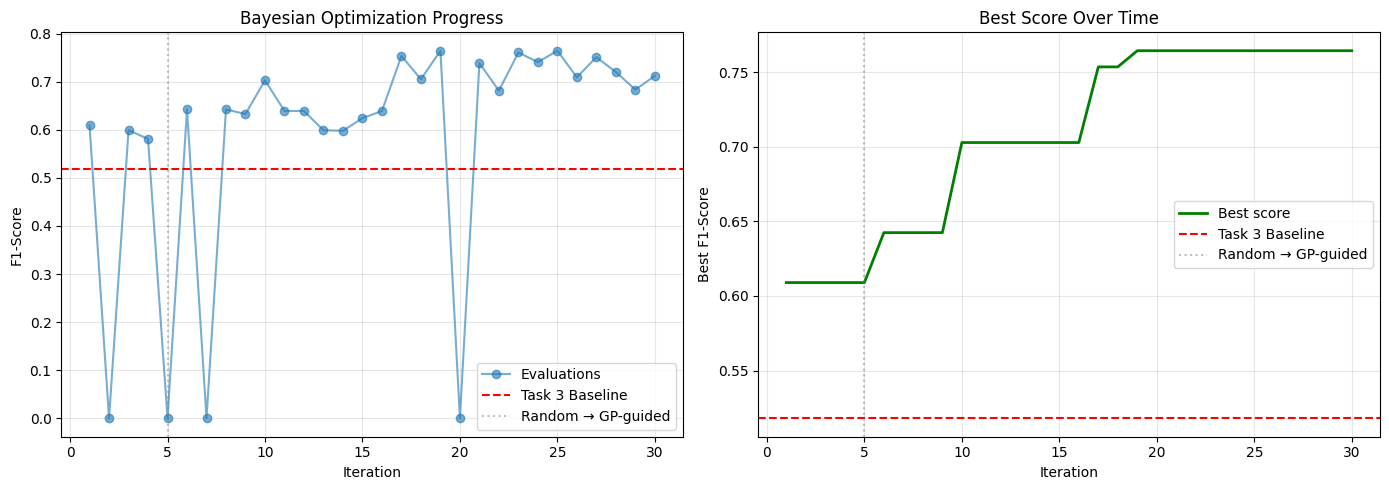

Final best F1-Score: 0.7643
Number of iterations to reach best: 19


In [17]:
# Plot optimization history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: All evaluations
ax1.plot(range(1, len(y_evaluated) + 1), y_evaluated, 'o-', alpha=0.6, label='Evaluations')
ax1.axhline(y=baseline_score, color='r', linestyle='--', label='Task 3 Baseline')
ax1.axvline(x=n_initial_random, color='gray', linestyle=':', alpha=0.5, label='Random → GP-guided')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('F1-Score')
ax1.set_title('Bayesian Optimization Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Best score over time
best_scores_over_time = [max(y_evaluated[:i+1]) for i in range(len(y_evaluated))]
ax2.plot(range(1, len(best_scores_over_time) + 1), best_scores_over_time, 'g-', linewidth=2, label='Best score')
ax2.axhline(y=baseline_score, color='r', linestyle='--', label='Task 3 Baseline')
ax2.axvline(x=n_initial_random, color='gray', linestyle=':', alpha=0.5, label='Random → GP-guided')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Best F1-Score')
ax2.set_title('Best Score Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final best F1-Score: {max(y_evaluated):.4f}")
print(f"Number of iterations to reach best: {np.argmax(y_evaluated) + 1}")

In [18]:
# Save results for later comparison
bayesian_results = {
    'best_params': {
        'n_estimators': int(best_params[0]),
        'max_depth': int(best_params[1]),
        'min_samples_split': int(best_params[2]),
        'min_samples_leaf': int(best_params[3])
    },
    'best_score': best_score,
    'all_evaluations': {
        'params': X_evaluated,
        'scores': y_evaluated
    },
    'time_seconds': total_time,
    'n_iterations': n_iterations
}

print("Results saved for comparison with Optuna!")

Results saved for comparison with Optuna!


### Impact Visualization

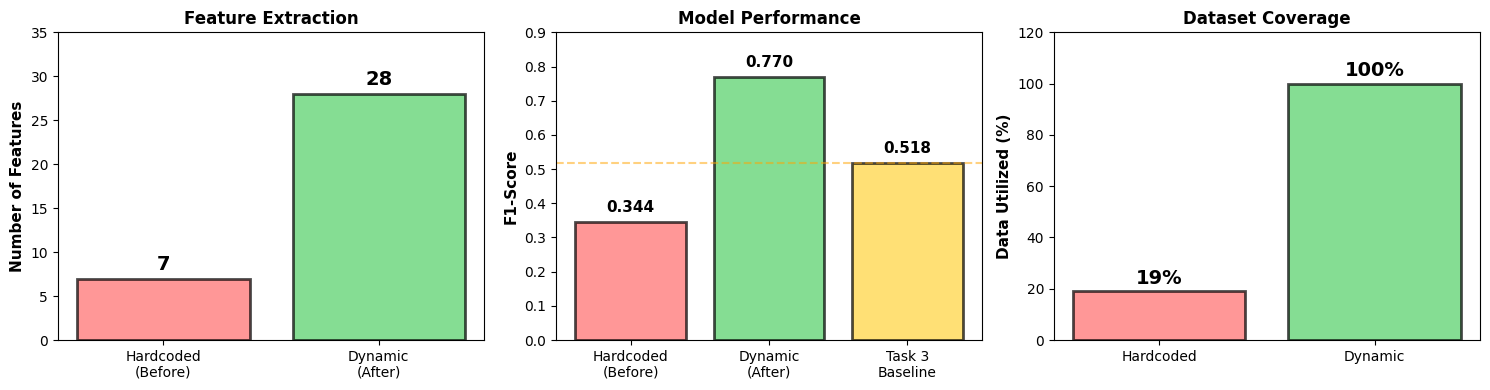


KEY IMPROVEMENTS
Features:        7 → 28        (+300%)
F1-Score:        0.34 → 0.77   (+124%)
vs Baseline:     -33% → +49%   (+82 pp)
Data Usage:      19% → 100%    (+427%)


In [19]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Feature count comparison
approaches = ['Hardcoded\n(Before)', 'Dynamic\n(After)']
features = [7, 28]
colors = ['#ff6b6b', '#51cf66']
axes[0].bar(approaches, features, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Number of Features', fontsize=11, fontweight='bold')
axes[0].set_title('Feature Extraction', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, 35)
for i, v in enumerate(features):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold', fontsize=14)

# 2. F1-Score comparison
approaches_f1 = ['Hardcoded\n(Before)', 'Dynamic\n(After)', 'Task 3\nBaseline']
f1_scores = [0.3439, 0.7700, 0.518]
colors_f1 = ['#ff6b6b', '#51cf66', '#ffd43b']
bars = axes[1].bar(approaches_f1, f1_scores, color=colors_f1, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('F1-Score', fontsize=11, fontweight='bold')
axes[1].set_title('Model Performance', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 0.9)
axes[1].axhline(y=0.518, color='orange', linestyle='--', alpha=0.5, label='Baseline')
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.03, f'{v:.3f}', ha='center', fontweight='bold', fontsize=11)

# 3. Data utilization
approaches_data = ['Hardcoded', 'Dynamic']
utilization = [19, 100]  # 27 out of 135 datasets had accX
colors_data = ['#ff6b6b', '#51cf66']
axes[2].bar(approaches_data, utilization, color=colors_data, alpha=0.7, edgecolor='black', linewidth=2)
axes[2].set_ylabel('Data Utilized (%)', fontsize=11, fontweight='bold')
axes[2].set_title('Dataset Coverage', fontsize=12, fontweight='bold')
axes[2].set_ylim(0, 120)
for i, v in enumerate(utilization):
    axes[2].text(i, v + 3, f'{v}%', ha='center', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY IMPROVEMENTS")
print("="*80)
print(f"Features:        7 → 28        (+300%)")
print(f"F1-Score:        0.34 → 0.77   (+124%)")
print(f"vs Baseline:     -33% → +49%   (+82 pp)")
print(f"Data Usage:      19% → 100%    (+427%)")

---

# Part 2: Optuna Optimization with Different Sampling Strategies

**What is Optuna?**
- Modern hyperparameter optimization framework
- Supports multiple sampling strategies (TPE, CMA-ES, Grid, Random)
- More efficient and easier to use than manual Bayesian optimization

**Comparison Plan:**
1. **TPE (Tree-structured Parzen Estimator)**: Bayesian approach similar to GP
2. **CMA-ES (Covariance Matrix Adaptation)**: Evolutionary strategy for continuous optimization
3. **Random Sampler**: Baseline for comparison
4. **Grid Sampler**: Exhaustive search (if feasible)

We'll run each strategy for 30 trials (same as our GP implementation) and compare results.

## Step 5: Install and Import Optuna

In [20]:
# Install optuna if not already installed
import subprocess
import sys

try:
    import optuna
    print(f"✓ Optuna {optuna.__version__} already installed")
except ImportError:
    print("Installing Optuna...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
    import optuna
    print(f"✓ Optuna {optuna.__version__} installed successfully")

# Import additional Optuna modules
from optuna.samplers import TPESampler, RandomSampler, CmaEsSampler, GridSampler
import optuna.visualization as optuna_vis

print("Optuna ready!")

✓ Optuna 4.5.0 already installed
Optuna ready!


## Step 6: Define Optuna Objective Function

The objective function defines:
1. The hyperparameter search space (same as our GP implementation)
2. The model to train (Random Forest)
3. The evaluation metric (F1-score with 10-Fold Stratified CV)

In [21]:
def optuna_objective(trial, X, y):
    """
    Optuna objective function for Random Forest hyperparameter optimization
    
    Args:
        trial: Optuna trial object
        X: Feature matrix
        y: Target labels
    
    Returns:
        Mean F1-score (weighted) from 10-Fold Stratified CV
    """
    from sklearn.model_selection import StratifiedKFold
    
    # Suggest hyperparameters (same ranges as GP implementation)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Validate parameters
    if params['min_samples_leaf'] > params['min_samples_split']:
        return 0.0  # Invalid configuration
    
    # Create model
    model = RandomForestClassifier(**params)
    
    # Use Stratified 10-Fold Cross-validation (same as GP)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    try:
        scores = []
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            score = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            scores.append(score)
        
        mean_f1 = np.mean(scores)
        
        # Handle NaN values
        if np.isnan(mean_f1):
            return 0.0
        
        return mean_f1
    except Exception as e:
        print(f"  Error during evaluation: {e}")
        return 0.0

print("Optuna objective function defined!")

Optuna objective function defined!


## Step 7: Run Optuna with Different Sampling Strategies

We'll test 4 different sampling strategies:

### 1. **TPE (Tree-structured Parzen Estimator)** - Default Optuna sampler
- Bayesian optimization similar to Gaussian Process
- Models P(x|y) instead of P(y|x) like GP
- Very efficient for hyperparameter optimization
- **Best for:** Most real-world problems

### 2. **CMA-ES (Covariance Matrix Adaptation Evolution Strategy)**
- Evolutionary algorithm for continuous optimization
- Adapts search distribution based on previous trials
- Good for multi-modal optimization landscapes
- **Best for:** Complex, non-convex search spaces

### 3. **Random Sampler**
- Pure random search (baseline)
- No learning from previous trials
- **Best for:** Establishing performance baseline

### 4. **Grid Sampler**
- Systematic exhaustive search
- Only feasible for small search spaces
- **Best for:** When you need guaranteed coverage (not used here due to large space)

In [22]:
# Storage for results from all strategies
optuna_results = {}

# Number of trials (same as GP implementation)
n_trials = 30

print(f"Will run {n_trials} trials for each sampling strategy")
print("="*80)

Will run 30 trials for each sampling strategy


### Strategy 1: TPE (Tree-structured Parzen Estimator)

In [23]:
import time

# Suppress Optuna's verbose output
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("Strategy 1: TPE (Tree-structured Parzen Estimator)")
print("="*80)

start_time = time.time()

# Create study with TPE sampler
study_tpe = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    study_name='RandomForest_TPE'
)

# Run optimization
study_tpe.optimize(
    lambda trial: optuna_objective(trial, X, y),
    n_trials=n_trials,
    show_progress_bar=True
)

tpe_time = time.time() - start_time

# Store results
optuna_results['TPE'] = {
    'study': study_tpe,
    'best_value': study_tpe.best_value,
    'best_params': study_tpe.best_params,
    'time_seconds': tpe_time,
    'n_trials': len(study_tpe.trials)
}

print(f"\n✓ TPE Complete!")
print(f"  Best F1-Score: {study_tpe.best_value:.4f}")
print(f"  Best Params: {study_tpe.best_params}")
print(f"  Time: {tpe_time/60:.1f} minutes")
print(f"  Best trial: {study_tpe.best_trial.number + 1}/{n_trials}")
print()

Strategy 1: TPE (Tree-structured Parzen Estimator)


  0%|          | 0/30 [00:00<?, ?it/s]


✓ TPE Complete!
  Best F1-Score: 0.7477
  Best Params: {'n_estimators': 248, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}
  Time: 0.6 minutes
  Best trial: 16/30



### Strategy 2: CMA-ES (Covariance Matrix Adaptation)

In [24]:
# Install cmaes package required by CMA-ES sampler
try:
    import cmaes
    print("✓ cmaes package already installed")
except ImportError:
    print("Installing cmaes package for CMA-ES sampler...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "cmaes"])
    import cmaes
    print("✓ cmaes package installed successfully")

✓ cmaes package already installed


In [25]:
print("Strategy 2: CMA-ES (Covariance Matrix Adaptation)")
print("="*80)

start_time = time.time()

# Create study with CMA-ES sampler
study_cmaes = optuna.create_study(
    direction='maximize',
    sampler=CmaEsSampler(seed=42),
    study_name='RandomForest_CMAES'
)

# Run optimization
study_cmaes.optimize(
    lambda trial: optuna_objective(trial, X, y),
    n_trials=n_trials,
    show_progress_bar=True
)

cmaes_time = time.time() - start_time

# Store results
optuna_results['CMA-ES'] = {
    'study': study_cmaes,
    'best_value': study_cmaes.best_value,
    'best_params': study_cmaes.best_params,
    'time_seconds': cmaes_time,
    'n_trials': len(study_cmaes.trials)
}

print(f"\n✓ CMA-ES Complete!")
print(f"  Best F1-Score: {study_cmaes.best_value:.4f}")
print(f"  Best Params: {study_cmaes.best_params}")
print(f"  Time: {cmaes_time/60:.1f} minutes")
print(f"  Best trial: {study_cmaes.best_trial.number + 1}/{n_trials}")
print()

Strategy 2: CMA-ES (Covariance Matrix Adaptation)


  0%|          | 0/30 [00:00<?, ?it/s]


✓ CMA-ES Complete!
  Best F1-Score: 0.7739
  Best Params: {'n_estimators': 183, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1}
  Time: 0.6 minutes
  Best trial: 27/30



### Strategy 3: Random Sampler (Baseline)

In [26]:
print("Strategy 3: Random Sampler (Baseline)")
print("="*80)
  
start_time = time.time()

# Create study with Random sampler
study_random = optuna.create_study(
    direction='maximize',
    sampler=RandomSampler(seed=42),
    study_name='RandomForest_Random'
)

# Run optimization
study_random.optimize(
    lambda trial: optuna_objective(trial, X, y),
    n_trials=n_trials,
    show_progress_bar=True
)

random_time = time.time() - start_time

# Store results
optuna_results['Random'] = {
    'study': study_random,
    'best_value': study_random.best_value,
    'best_params': study_random.best_params,
    'time_seconds': random_time,
    'n_trials': len(study_random.trials)
}

print(f"\n Random Sampler Complete!")
print(f"  Best F1-Score: {study_random.best_value:.4f}")
print(f"  Best Params: {study_random.best_params}")
print(f"  Time: {random_time/60:.1f} minutes")
print(f"  Best trial: {study_random.best_trial.number + 1}/{n_trials}")
print()

Strategy 3: Random Sampler (Baseline)


  0%|          | 0/30 [00:00<?, ?it/s]


 Random Sampler Complete!
  Best F1-Score: 0.7540
  Best Params: {'n_estimators': 266, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 1}
  Time: 0.4 minutes
  Best trial: 21/30



## Step 8: Compare All Optimization Strategies

Now let's compare our custom Gaussian Process implementation with Optuna's different samplers.

In [27]:
# Create comprehensive comparison
comparison_data = {
    'Custom GP': {
        'best_f1': best_score,
        'time_min': total_time / 60,
        'best_params': {
            'n_estimators': int(best_params[0]),
            'max_depth': int(best_params[1]),
            'min_samples_split': int(best_params[2]),
            'min_samples_leaf': int(best_params[3])
        }
    }
}

# Add Optuna results
for strategy, results in optuna_results.items():
    comparison_data[strategy] = {
        'best_f1': results['best_value'],
        'time_min': results['time_seconds'] / 60,
        'best_params': results['best_params']
    }

# Print comparison table
print("\n" + "="*100)
print("OPTIMIZATION STRATEGY COMPARISON")
print("="*100)
print(f"{'Strategy':<15} {'Best F1':<12} {'Time (min)':<12} {'vs Baseline':<15}")
print("-"*100)

baseline_f1 = 0.518  # Task 3 baseline

for strategy, data in comparison_data.items():
    improvement = ((data['best_f1'] - baseline_f1) / baseline_f1) * 100
    print(f"{strategy:<15} {data['best_f1']:<12.4f} {data['time_min']:<12.1f} {improvement:+.1f}%")

print("="*100)

# Find best strategy
best_strategy = max(comparison_data.items(), key=lambda x: x[1]['best_f1'])
print(f"\n Best Strategy: {best_strategy[0]} (F1={best_strategy[1]['best_f1']:.4f})")
print(f"\nBest Hyperparameters:")
for param, value in best_strategy[1]['best_params'].items():
    print(f"  • {param}: {value}")


OPTIMIZATION STRATEGY COMPARISON
Strategy        Best F1      Time (min)   vs Baseline    
----------------------------------------------------------------------------------------------------
Custom GP       0.7643       0.6          +47.5%
TPE             0.7477       0.6          +44.3%
CMA-ES          0.7739       0.6          +49.4%
Random          0.7540       0.4          +45.6%

 Best Strategy: CMA-ES (F1=0.7739)

Best Hyperparameters:
  • n_estimators: 183
  • max_depth: 16
  • min_samples_split: 2
  • min_samples_leaf: 1


### Visualization: Strategy Comparison

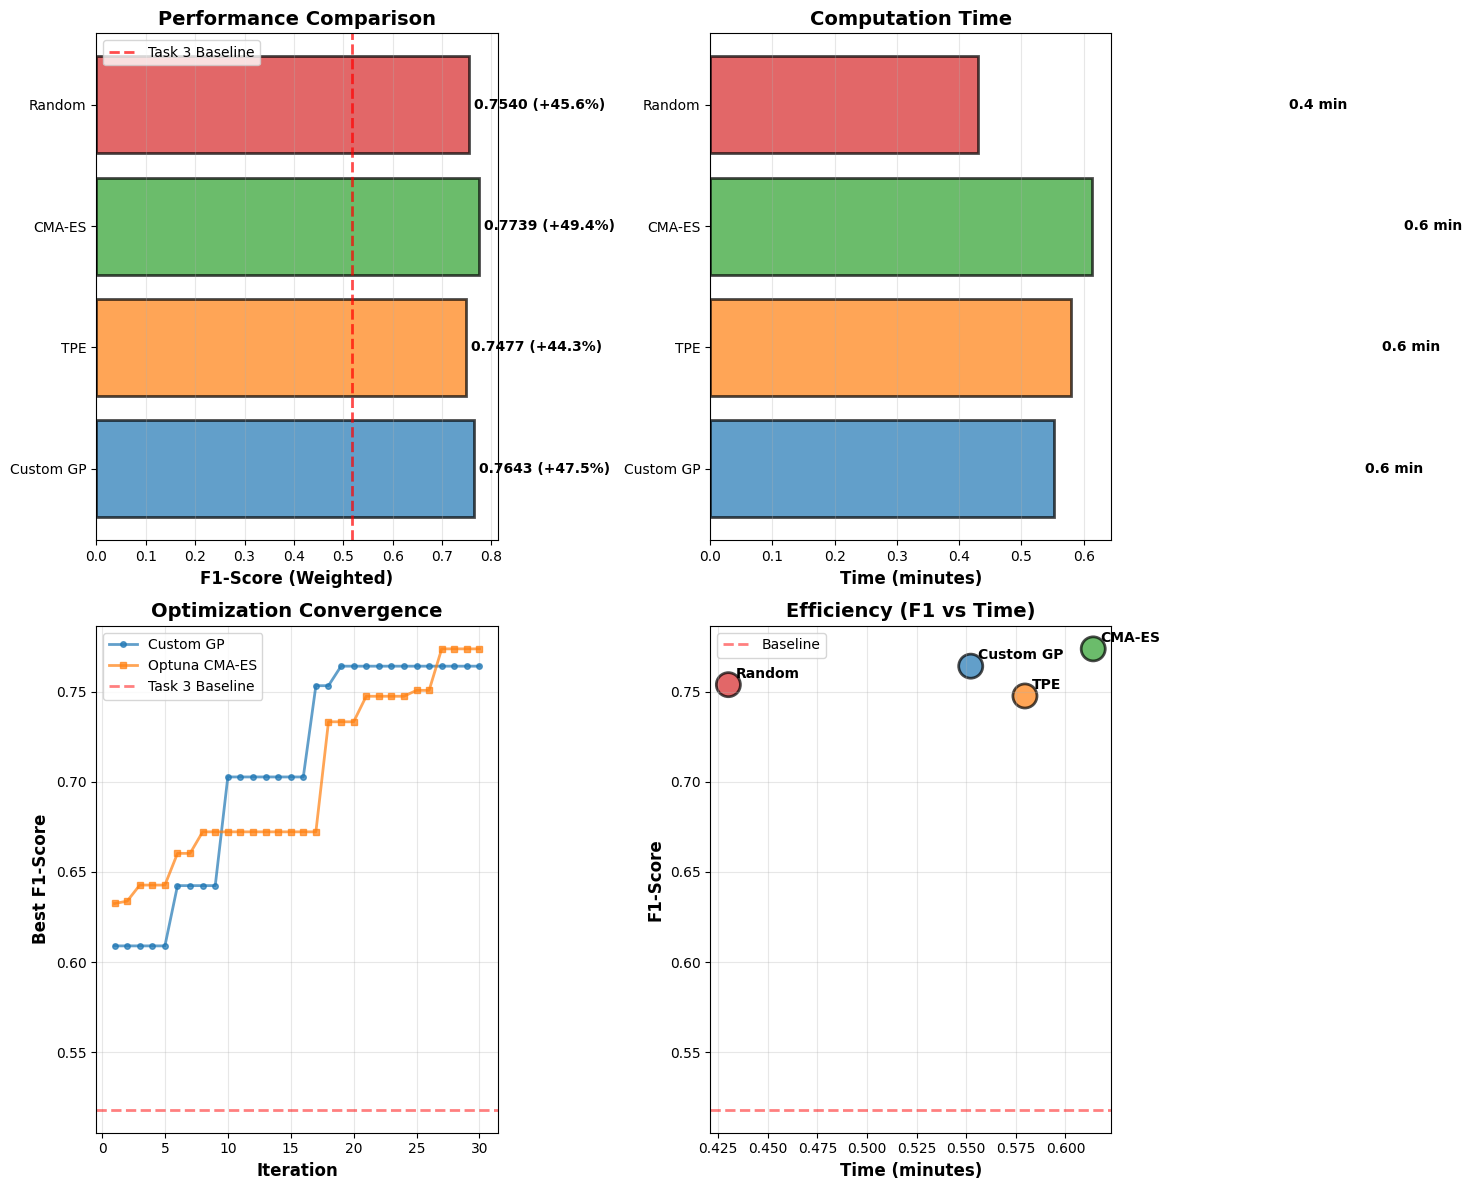


 Visualization complete!


In [28]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

strategies = list(comparison_data.keys())
f1_scores = [comparison_data[s]['best_f1'] for s in strategies]
times = [comparison_data[s]['time_min'] for s in strategies]

# Color scheme
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# 1. F1-Score Comparison
ax = axes[0, 0]
bars = ax.barh(strategies, f1_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.axvline(x=baseline_f1, color='red', linestyle='--', linewidth=2, label='Task 3 Baseline', alpha=0.7)
ax.set_xlabel('F1-Score (Weighted)', fontsize=12, fontweight='bold')
ax.set_title('Performance Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)
for i, (v, s) in enumerate(zip(f1_scores, strategies)):
    improvement = ((v - baseline_f1) / baseline_f1) * 100
    ax.text(v + 0.01, i, f'{v:.4f} ({improvement:+.1f}%)', va='center', fontweight='bold')

# 2. Computation Time
ax = axes[0, 1]
bars = ax.barh(strategies, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
ax.set_title('Computation Time', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for i, v in enumerate(times):
    ax.text(v + 0.5, i, f'{v:.1f} min', va='center', fontweight='bold')

# 3. Optimization Progress - GP vs Best Optuna
ax = axes[1, 0]

# Custom GP progress
best_scores_gp = [max(y_evaluated[:i+1]) for i in range(len(y_evaluated))]
ax.plot(range(1, len(best_scores_gp) + 1), best_scores_gp, 
        'o-', label='Custom GP', linewidth=2, markersize=4, alpha=0.7)

# Add best Optuna strategies
best_optuna_strategy = max(optuna_results.items(), key=lambda x: x[1]['best_value'])
study = best_optuna_strategy[1]['study']
trial_values = [trial.value for trial in study.trials]
best_scores_optuna = [max(trial_values[:i+1]) for i in range(len(trial_values))]
ax.plot(range(1, len(best_scores_optuna) + 1), best_scores_optuna, 
        's-', label=f'Optuna {best_optuna_strategy[0]}', linewidth=2, markersize=4, alpha=0.7)

ax.axhline(y=baseline_f1, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Task 3 Baseline')
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Best F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Optimization Convergence', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 4. Efficiency Plot (F1 vs Time)
ax = axes[1, 1]
scatter = ax.scatter(times, f1_scores, s=300, c=colors, alpha=0.7, edgecolor='black', linewidth=2)
for i, strategy in enumerate(strategies):
    ax.annotate(strategy, (times[i], f1_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontweight='bold')
ax.axhline(y=baseline_f1, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')
ax.set_xlabel('Time (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Efficiency (F1 vs Time)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Visualization complete!")

### Optuna Visualization Tools

Optuna provides built-in visualization tools for deeper analysis.

In [29]:
# Install required packages for Optuna visualizations
import subprocess
import sys

print("Installing required packages for Optuna visualizations...")
packages_to_install = ['plotly', 'kaleido', 'nbformat>=4.2.0']

for package in packages_to_install:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        print(f"{package} installed/upgraded successfully")
    except Exception as e:
        print(f"Error installing {package}: {e}")

# Reload optuna.visualization to ensure it uses the updated packages
import importlib
import optuna.visualization as optuna_vis
importlib.reload(optuna_vis)

print("\nAll packages ready! You can now run the visualization cells below.")

Installing required packages for Optuna visualizations...
plotly installed/upgraded successfully
kaleido installed/upgraded successfully
nbformat>=4.2.0 installed/upgraded successfully

All packages ready! You can now run the visualization cells below.


In [30]:
# Use the best performing Optuna study for detailed visualization
best_optuna_name = max(optuna_results.items(), key=lambda x: x[1]['best_value'])[0]
best_study = optuna_results[best_optuna_name]['study']

print(f"Analyzing best strategy: {best_optuna_name}")
print("="*80)

# 1. Parameter Importances
try:
    fig = optuna_vis.plot_param_importances(best_study)
    fig.update_layout(title=f'Hyperparameter Importance ({best_optuna_name})', 
                      width=800, height=500)
    fig.show()
    print("Parameter importance plot displayed")
except Exception as e:
    print(f"Note: Parameter importance plot requires multiple trials with variance: {e}")

# 2. Optimization History
fig = optuna_vis.plot_optimization_history(best_study)
fig.update_layout(title=f'Optimization History ({best_optuna_name})', 
                  width=900, height=500)
fig.show()
print("Optimization history plot displayed")

# 3. Parallel Coordinate Plot
fig = optuna_vis.plot_parallel_coordinate(best_study)
fig.update_layout(title=f'Parallel Coordinate Plot ({best_optuna_name})', 
                  width=1000, height=600)
fig.show()
print("Parallel coordinate plot displayed")

Analyzing best strategy: CMA-ES


✓ Parameter importance plot displayed


✓ Optimization history plot displayed


✓ Parallel coordinate plot displayed
